In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.signal import find_peaks
%matplotlib widget

In [25]:
# Pipeline for extracting visibility from each data set

def avg_visibility(data,name,down,up,plot):
    
    # Data analysis pipeline
    ds = pd.read_csv(data, header=1)
    ds_filtered = ds.loc[down:up]['raw data']
    
    window_size = 80
    mean = ds_filtered.rolling(window = window_size).sum() / window_size
    mean = mean.shift(int(-window_size/2)).dropna()
    
    # Root-mean squared
    subtraction = (ds_filtered - mean).dropna()
    subtraction_squared = [x**2 for x in subtraction]
    rms = math.sqrt(sum(subtraction_squared)/len(subtraction))
    upper_limit = mean + rms
    lower_limit = mean - rms
    vis = rms / mean.dropna()
    
    if plot:
        # Plotting
        plt.close("all")
        
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        
        ax.plot(ds['raw data'], label="15 deg data")
        ax.plot(mean.index,mean, label="Mean")
        ax.plot(mean.index,upper_limit, label="Mean $+\:\sigma$")
        ax.plot(mean.index,lower_limit, label="Mean $-\:\sigma$")
        ax.legend()
        ax.set_ylabel("Brightness (a.u.)")
        ax.set_xlabel("Position (a.u.)")
        
        '''
        ax[0].plot(ds['raw data'], label="15 deg data")
        ax[0].set_xlim(down+window_size/2, up-window_size/2)
        ax[0].plot(mean.index,mean, label="Mean")
        ax[0].plot(mean.index,upper_limit, label="Mean $+\:\sigma$")
        ax[0].plot(mean.index,lower_limit, label="Mean $-\:\sigma$")
        ax[0].legend()
        ax[0].set_ylabel("Brightness (a.u.)")
        ax[0].set_xlabel("Position (a.u.)")

        ax[1].plot(vis)
        ax[1].set_xlim(down+window_size/2, up-window_size/2)
        ax[1].axhline(np.average(vis), color="C1", label="Mean visibility")
        ax[1].legend()
        ax[1].set_ylabel("Visibility")
        ax[1].set_xlabel("Index")
        '''
        
        plt.tight_layout()
        plt.show()
        plt.savefig("data_raw", dpi=300)

        
    return np.average(vis)

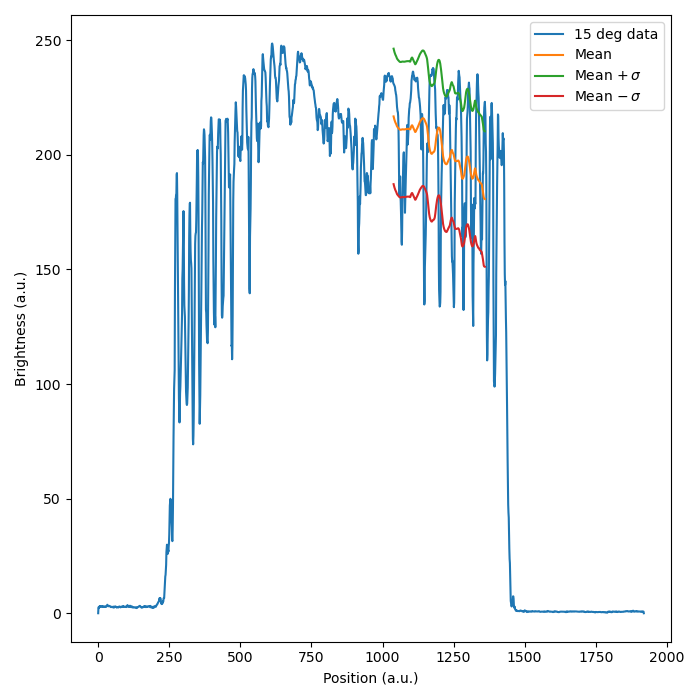

0.14606774829394178

In [26]:
down = 1000
up = 1400

avg_visibility("15pol.csv","15deg",down,up, True)

In [5]:
# Simulation code

def QEResponse(delay,phiUpper,phiLower,phiOutput,outputPolarizer):

    
    Initial = np.array([1,1,0,0])
    Initial = Initial/np.linalg.norm(Initial)

    BS1 = np.array([[-1,0,1,0],
                    [0,-1,0,1],
                    [1,0,1,0],
                    [0,1,0,1]])*(1/np.sqrt(2))

    BS2 = np.array([[1,0,-1,0],
                    [0,1,0,-1],
                    [1,0,1,0],
                    [0,1,0,1]])*(1/np.sqrt(2))

    M = np.array([[-1,0,0,0],
                  [0,-1,0,0],
                  [0,0,-1,0],
                  [0,0,0,-1]])

    PS = np.array([[np.exp(1j*delay),0,0,0],
                    [0,np.exp(1j*delay),0,0],
                    [0,0,1,0],
                    [0,0,0,1]])


    PU = polarizerMatrix(phiUpper,'upper')
    PL = polarizerMatrix(phiLower,'lower')



    if outputPolarizer:
        Pout = polarizerMatrix(phiOutput,'upper')
    else:
        Pout = np.eye(4)    

    F = Pout@BS2@PS@M@PL@PU@BS1@Initial

    return F



def polarizerMatrix(phi,arm):

    phi = np.deg2rad(phi)

    if arm == 'upper':
        M = np.array([[np.cos(phi)**2,np.cos(phi)*np.sin(phi),0,0],
                    [np.cos(phi)*np.sin(phi),np.sin(phi)**2,0,0],
                    [0,0,1,0],
                    [0,0,0,1]])

    elif arm == 'lower':

        M = np.array([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,np.cos(phi)**2,np.cos(phi)*np.sin(phi)],
                      [0,0,np.cos(phi)*np.sin(phi),np.sin(phi)**2]])
    return M

In [6]:
# Simulating interference pattern experiment

# number of phase shifts
Nphase = 100

#phase shift vector
delay = np.linspace(0,2*np.pi,Nphase)

F = np.zeros((4,Nphase),'complex128')
visibility = np.zeros(Nphase)
vis = []
angles = list(range(0,181,1))

for a in angles:
    #polarizer angles in degrees
    phiUpper = 0
    phiLower = a
    phiOutput = 45

    #3rd polarizer in upper path
    outputPolarizer = False


    for ii in range(len(delay)):
        F[:,ii] = QEResponse(delay[ii],phiUpper,phiLower,phiOutput,outputPolarizer)


    intensity = np.abs(F)**2
    top = intensity[0,:]+intensity[1,:]
    bottom = intensity[2,:]+intensity[3,:]
    vis.append((np.max(top) - np.min(top))/(np.max(top) + np.min(top)))

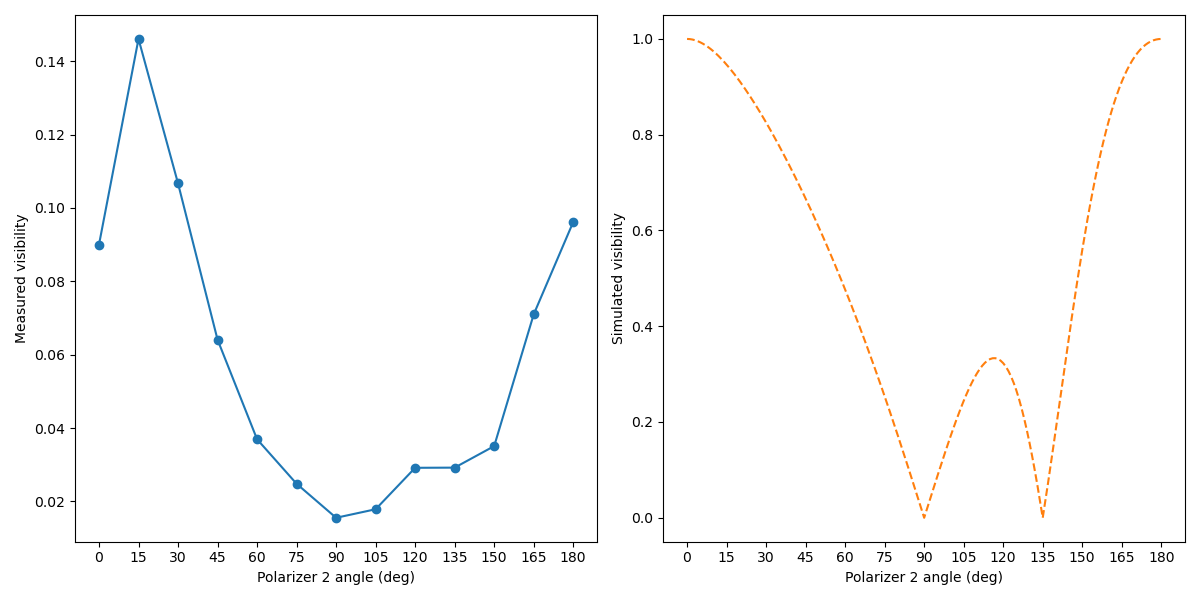

In [7]:
visibility = []
down = 1000
up = 1400

visibility.append(avg_visibility("0pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("15pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("30pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("45pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("60pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("75pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("90pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("105pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("120pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("135pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("150pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("165pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("180pol.csv","0 deg",down,up,False)) 

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(range(0,181,15),visibility, marker='o', color='C0')
ax[1].plot(vis, linestyle='--', color="C1")
ax[0].set_xlabel("Polarizer 2 angle (deg)")
ax[1].set_xlabel("Polarizer 2 angle (deg)")
ax[0].set_ylabel("Measured visibility")
ax[1].set_ylabel("Simulated visibility")
ax[0].set_xticks(range(0,181,15))
ax[1].set_xticks(range(0,181,15))
plt.tight_layout()
plt.savefig("Pol2", dpi=300)

In [8]:
# Simulating quantum eraser experiment

# number of phase shifts
Nphase = 100

#phase shift vector
delay = np.linspace(0,2*np.pi,Nphase)

F = np.zeros((4,Nphase),'complex128')
visibility = np.zeros(Nphase)
vis = []
angles = list(range(0,91,1))

for a in angles:
    #polarizer angles in degrees
    phiUpper = 0
    phiLower = 90
    phiOutput = a

    #3rd polarizer in upper path
    outputPolarizer = True


    for ii in range(len(delay)):
        F[:,ii] = QEResponse(delay[ii],phiUpper,phiLower,phiOutput,outputPolarizer)


    intensity = np.abs(F)**2
    top = intensity[0,:]+intensity[1,:]
    bottom = intensity[2,:]+intensity[3,:]
    vis.append((np.max(top) - np.min(top))/(np.max(top) + np.min(top)))

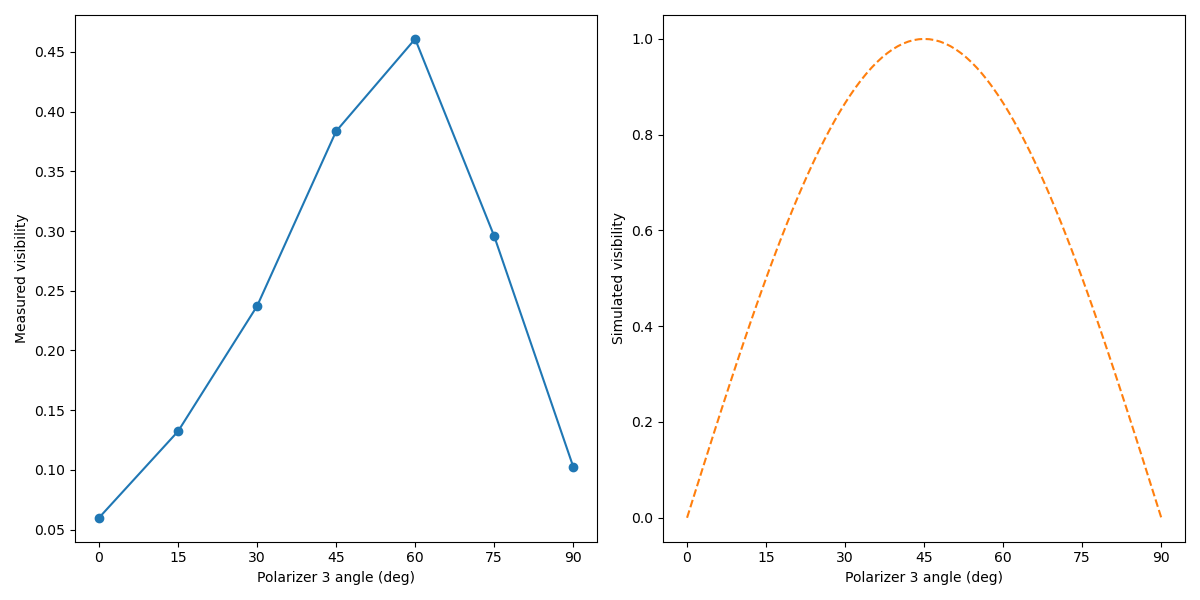

In [10]:
visibility = []
down = 1200
up = 1400

visibility.append(avg_visibility("90.0pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("90.15pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("90.30pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("90.45pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("90.60pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("90.75pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("90.90pol.csv","0 deg",down,up,False))

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(range(0,91,15),visibility, marker='o', color='C0')
ax[1].plot(vis, linestyle='--', color="C1")
ax[0].set_xlabel("Polarizer 3 angle (deg)")
ax[1].set_xlabel("Polarizer 3 angle (deg)")
ax[0].set_ylabel("Measured visibility")
ax[1].set_ylabel("Simulated visibility")
ax[0].set_xticks(range(0,91,15))
ax[1].set_xticks(range(0,91,15))
plt.tight_layout()
plt.savefig("Pol3", dpi=300)

Checking the set of dat with second polarizer at 45 deg.

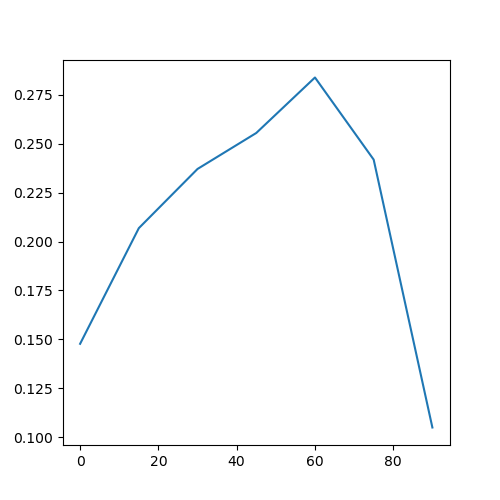

In [ ]:
visibility = []
down = 1200
up = 1400

visibility.append(avg_visibility("45.0pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("45.15pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("45.30pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("45.45pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("45.60pol.csv","0 deg",down,up,False))
visibility.append(avg_visibility("45.75pol.csv","15 deg",down,up,False))
visibility.append(avg_visibility("45.90pol.csv","0 deg",down,up,False))

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(0,91,15),visibility)

Check for decline of brightness, like in polarizer

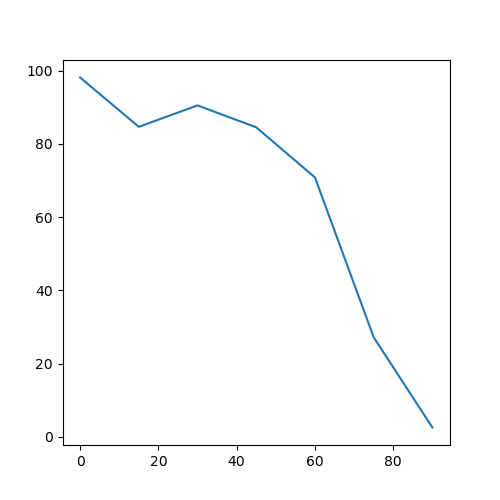

In [ ]:
brightness=[]

for name in ["0.0pol.csv", "0.15pol.csv", "0.30pol.csv", "0.45pol.csv", "0.60pol.csv", "0.75pol.csv", "0.90pol.csv"]:
    brightness.append(pd.read_csv(name, header=1)["raw data"].iloc[1350])

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(0,91,15),brightness)

def avg_visibility(data,name,down,up):
    
    # Data analysis pipeline
    ds = pd.read_csv(data, header=1)
    ds_filtered = ds.loc[down:up]['raw data']
    
    peaks, _ = find_peaks(ds_filtered)
    throughs, _ = find_peaks(-ds_filtered)
    
    extrema = np.array(list(zip(peaks,throughs))).flatten()
    extrema_v = ds['raw data'][extrema].reset_index(drop=True)
    
    vis = []
    # for i in range(np.minimum(len(peaks), len(throughs))):
    for i in range(round(len(extrema_v)/2)):
        v = abs(extrema_v[2*i] - extrema_v[2*i+1]) 
        # v = (peaks[i] - throughs[i]) / (peaks[i] + throughs[i])
        vis.append(v)
        
    # Plotting
    plt.close("all")
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(ds['raw data'], label=name)
    ax[0].plot(peaks + down, ds['raw data'][peaks + down], "x")
    ax[0].plot(throughs + down, ds['raw data'][throughs + down], "x")
    ax[0].legend()
    ax[0].set_ylabel("Brightness (a.u.)")
    ax[0].set_xlabel("Position (a.u.)")

    ax[1].plot(vis, label=name)
    ax[1].legend()
    ax[1].set_ylabel("Visibility")
    ax[1].set_xlabel("Index")
    
    plt.show()
        
    return np.average(vis)